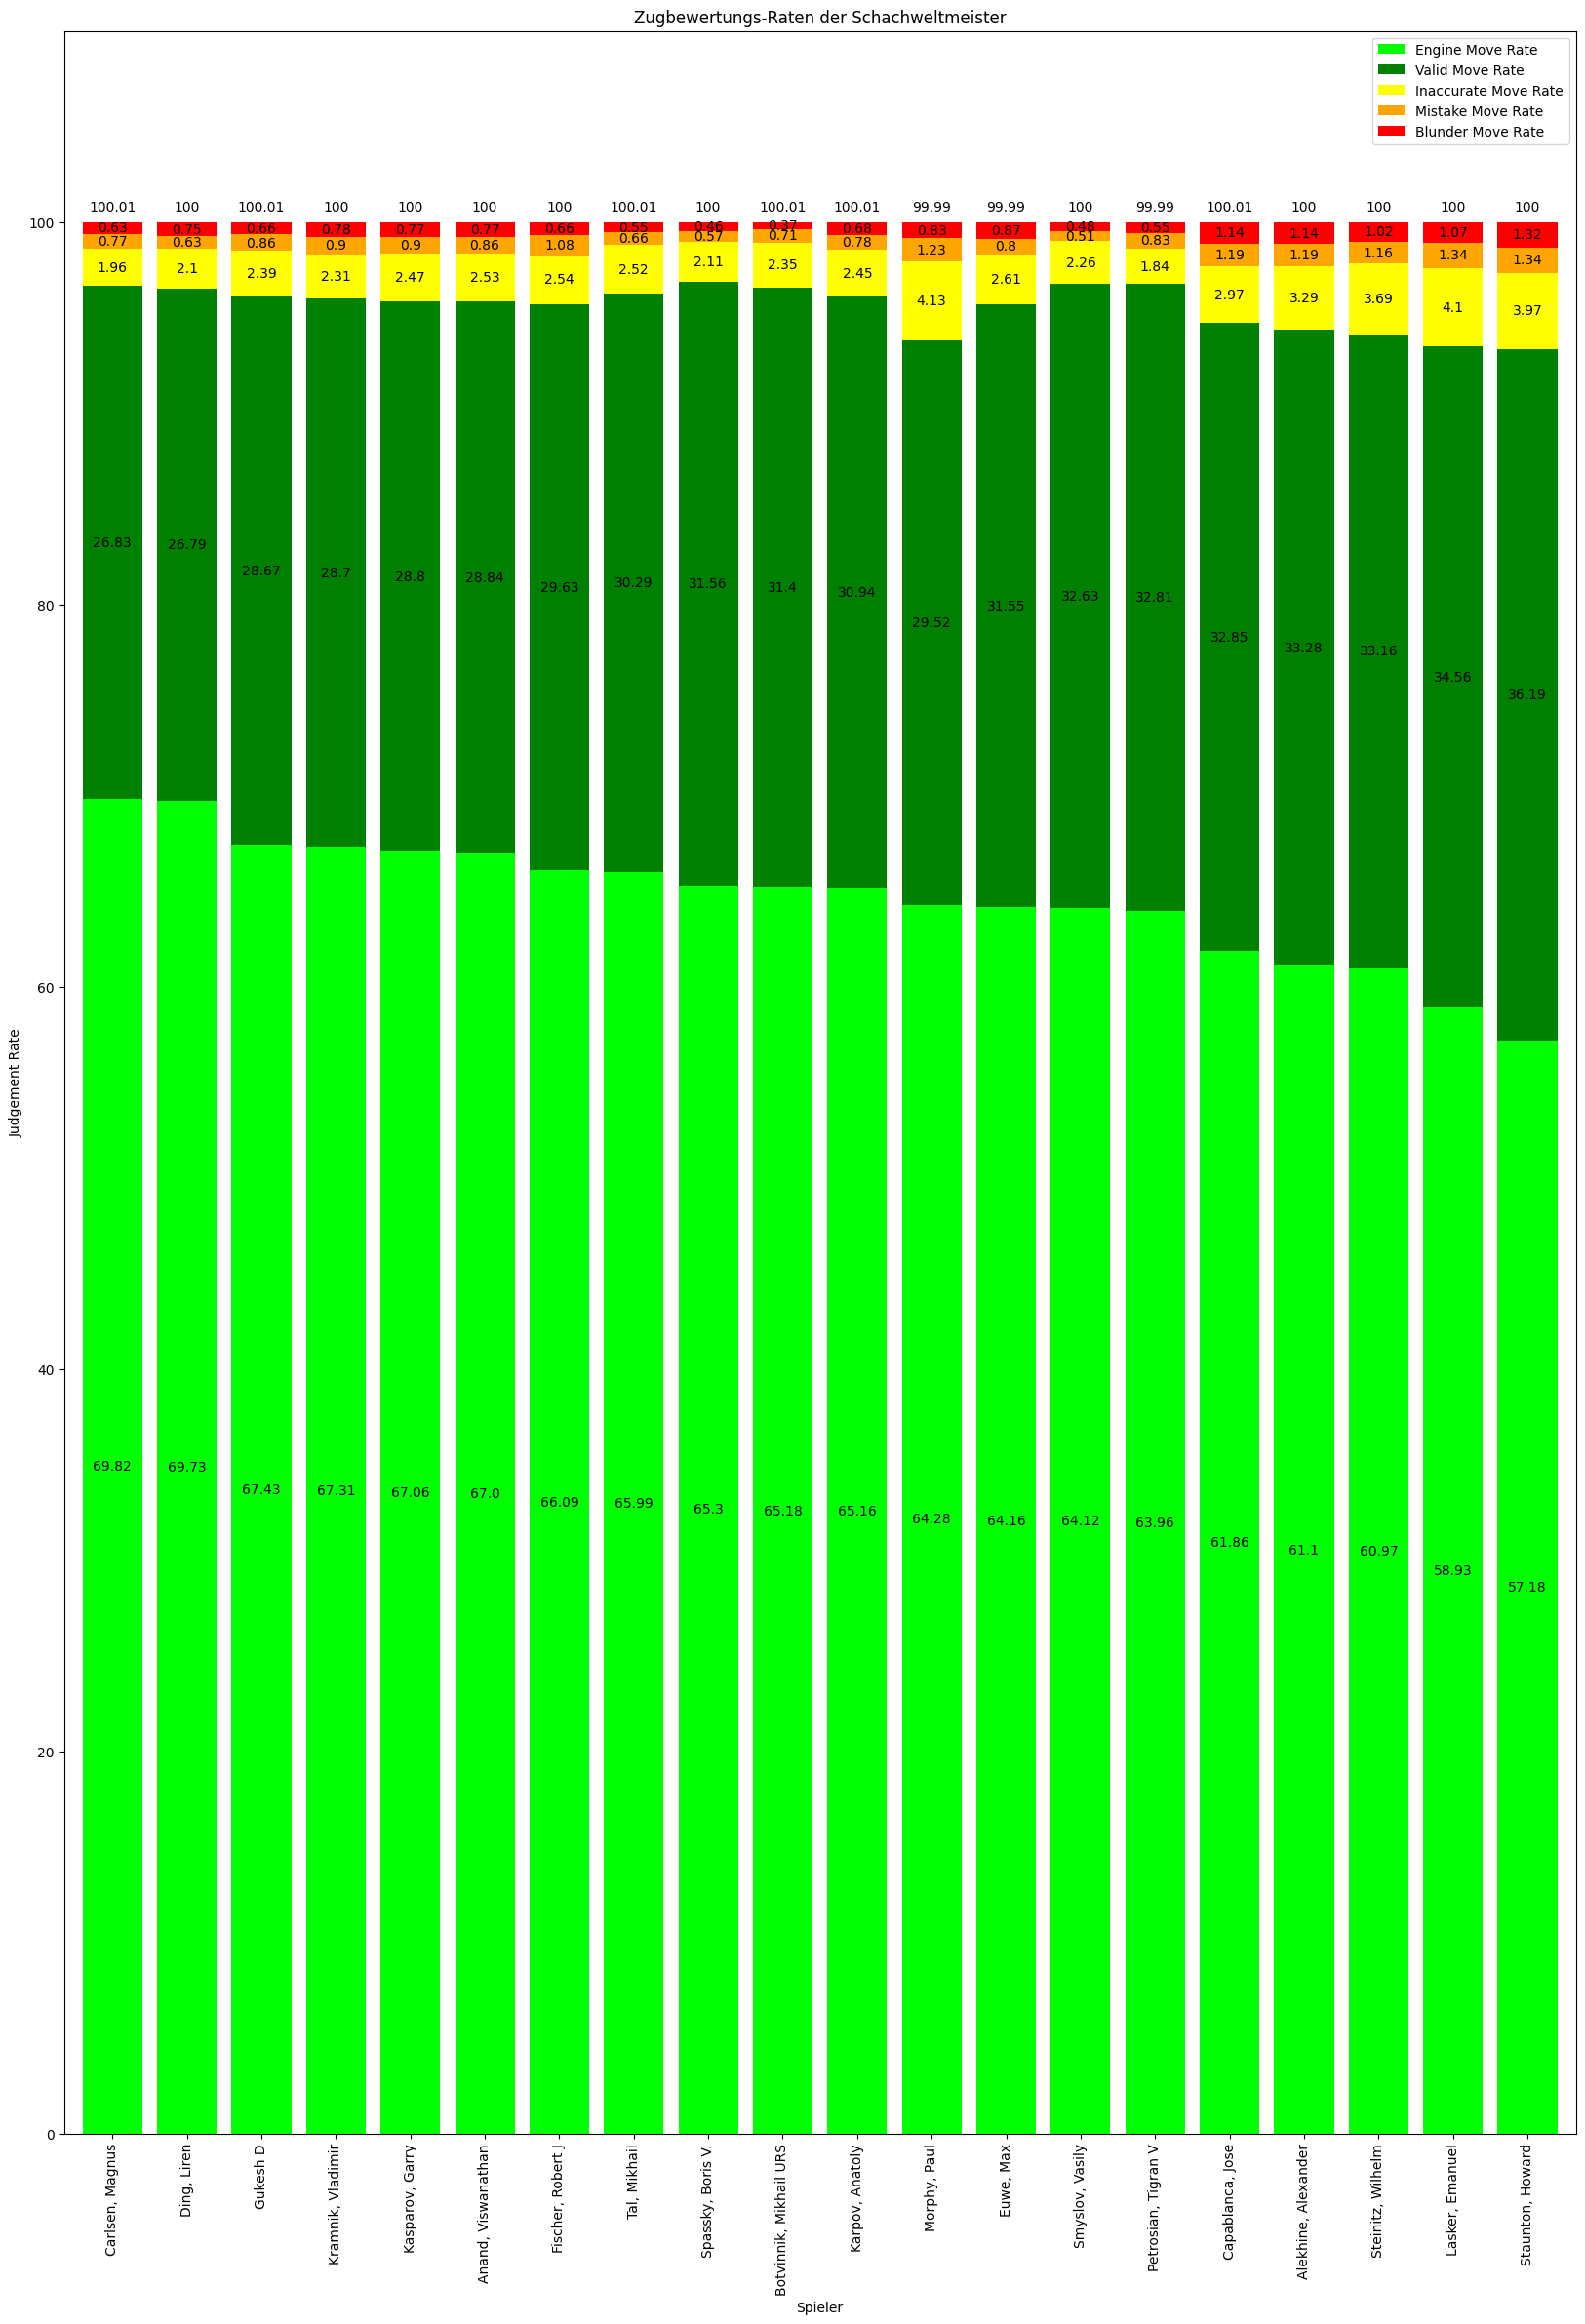

In [11]:
import sys
import os
import getpass
import mariadb
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
    
def connect(p_password):
    global conn
    global cursor
    
    # Database connection details
    db_config = {
        "user": "chess_user",
        "password": p_password,
        "host": "localhost",
        "database": "chess",
        "port": 3306,  # Standard port for MariaDB
    }
    # Establishing the connection
    conn = mariadb.connect(**db_config)
    # Disable autocommit
    conn.autocommit = False
    # Create a cursor to execute queries
    cursor = conn.cursor()

def disconnect():
    cursor.close()
    conn.close()

def get_data():
        df = pd.read_sql_query("""select
	Spieler,
	round(CountEngineMoves / CountMoves * 100, 2) "Engine Move Rate",
	round(CountValidMoves / CountMoves * 100, 2) "Valid Move Rate",
	round(CountInaccurateMoves / CountMoves * 100, 2) "Inaccurate Move Rate",
	round(CountMistakeMoves / CountMoves * 100, 2) "Mistake Move Rate",
	round(CountBlunderMoves / CountMoves * 100, 2) "Blunder Move Rate"
from
	(
	select
		p.name Spieler,
		sum(case when ((p.id = g.white_player_id and mod(po.half_move_num, 2) = 1) or (p.id = g.black_player_id and mod(po.half_move_num, 2) = 0)) then 1 else 0 end) CountMoves,
		sum(case when ((p.id = g.white_player_id and mod(po.half_move_num, 2) = 1) or (p.id = g.black_player_id and mod(po.half_move_num, 2) = 0)) and dap.judgement = 'ENGINE' then 1 else 0 end) CountEngineMoves,
		sum(case when ((p.id = g.white_player_id and mod(po.half_move_num, 2) = 1) or (p.id = g.black_player_id and mod(po.half_move_num, 2) = 0)) and dap.judgement is null then 1 else 0 end) CountValidMoves,
		sum(case when ((p.id = g.white_player_id and mod(po.half_move_num, 2) = 1) or (p.id = g.black_player_id and mod(po.half_move_num, 2) = 0)) and dap.judgement = 'INACCURACY' then 1 else 0 end) CountInaccurateMoves,
		sum(case when ((p.id = g.white_player_id and mod(po.half_move_num, 2) = 1) or (p.id = g.black_player_id and mod(po.half_move_num, 2) = 0)) and dap.judgement = 'MISTAKE' then 1 else 0 end) CountMistakeMoves,
		sum(case when ((p.id = g.white_player_id and mod(po.half_move_num, 2) = 1) or (p.id = g.black_player_id and mod(po.half_move_num, 2) = 0)) and dap.judgement = 'BLUNDER' then 1 else 0 end) CountBlunderMoves
	from
		player p
	join game g on
		(p.id = g.black_player_id
			or p.id = g.white_player_id )
	join position po on
		po.game_id = g.id
	join da_position dap on
		dap.position_id = po.id
	where
		p.name in ('Staunton, Howard', 'Morphy, Paul', 'Steinitz, Wilhelm', 'Lasker, Emanuel', 'Capablanca, Jose', 'Alekhine, Alexander', 'Euwe, Max',
'Botvinnik, Mikhail URS', 'Smyslov, Vasily', 'Smyslov, V.', 'Tal, Mikhail', 'Petrosian, Tigran V', 'Spassky, Boris V.', 'Fischer, Robert J', 'Karpov, Anatoly',
'Kasparov, Garry', 'Kasparov, G.', 'Kramnik, Vladimir', 'Anand, Viswanathan', 'Carlsen, Magnus', 'Ding, Liren', 'Gukesh D')
	group by
		case
			when p.name in ('Kasparov, Garry', 'Kasparov, G.') then 'Kasparov, Garry'
			when p.name in ('Smyslov, Vasily', 'Smyslov, V.') then 'Smyslov, Vasily'
			else p.name
		end) t
order by
	2 desc, 3 desc""", conn)
        return(df)

def visualize_data(p_df): 
    color=['lime', 'green', 'yellow', 'orange', 'red']
    ax=p_df.plot(x='Spieler', kind='bar', width=.8, stacked=True, figsize=(20,28), color=color, ylabel="Judgement Rate", title="Zugbewertungs-Raten der Schachweltmeister")
    plt.bar_label(ax.containers[-1], rotation = 0, label_type = "edge", padding=6)
    plt.bar_label(ax.containers[0], labels=p_df['Engine Move Rate'], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[1], labels=p_df['Valid Move Rate'], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[2], labels=p_df['Inaccurate Move Rate'], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[3], labels=p_df['Mistake Move Rate'], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[4], labels=p_df['Blunder Move Rate'], rotation = 0, label_type = "center")
    plt.ylim([0, 110])
    plt.show()

    
def main():
    # try to get passwd from .env file
    load_dotenv()
    passwd = os.getenv("passwd")
    
    # If password not provided, prompt securely
    if not passwd:
        try:
            passwd = getpass.getpass(prompt="Enter database password: ")
        except (KeyboardInterrupt, EOFError):
            print("\nPassword input cancelled.")
            sys.exit(1)

    # Validate password input
    if not passwd.strip():
        print("Error: Database password cannot be empty.")
        sys.exit(1)

    # connect to database
    try:
        connect(passwd)
        df = get_data()
        visualize_data(df)
        disconnect()
    except Exception as e:
        print(e)
        try:
            disconnect()
        except:
            pass
        sys.exit(1)


if __name__ == "__main__":
    main()
    
